Во всех заданиях при фильтрации заказов я исходила из того, что если заказ не подтвержден, то он не сделан, и добавляла условие 

```order_status = 'Approved ```

## Задание 1
```
-- Вывести все уникальные бренды, у которых есть хотя бы один продукт со стандартной стоимостью
-- выше 1500 долларов, суммарными продажами [хотя бы одного продукта - прим. студента] не менее 1000 единиц.

-- на этом этапе достаем уникальные бренды; они и так уникальные в подзапросе,
-- но при изменении исходных данных подзапрос может отдать дубликаты брендов.
select distinct brand
from
	( -- выбираем продукты со стандартной стоимостью > 1500 и суммарными продажами >= 1000 единиц
	select 
		brand,
		product_id,
		sum(quantity) as total_amount,
		max(item_standard_cost_at_sale) as max_cost
	from hw2.order_items items left join hw2.product_cor using(product_id)
	group by brand,product_id
	having max(item_standard_cost_at_sale)>1500
		and sum(quantity) >1000
		) as products
  ```
  
  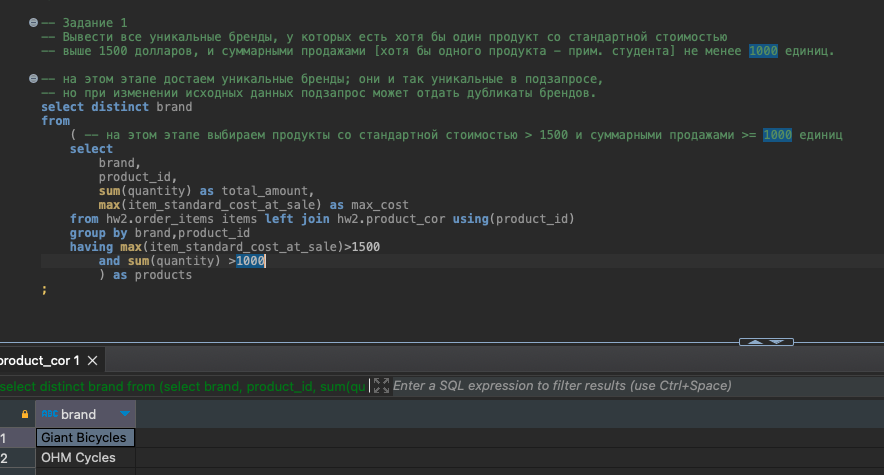

## Задание 2
```
-- Для каждого дня в диапазоне с 2017-04-01 по 2017-04-09 включительно вывести количество
-- подтвержденных онлайн-заказов и количество уникальных клиентов, совершивших эти заказы.

select 
	order_date,
	count(distinct order_id) as uniq_orders,
	count(distinct customer_id) as uniq_customers
from hw2.orders
where 
	order_date between '2017-04-01' and '2017-04-09'
	and online_order
	and order_status = 'Approved'
	group by 1
	order by 1
```

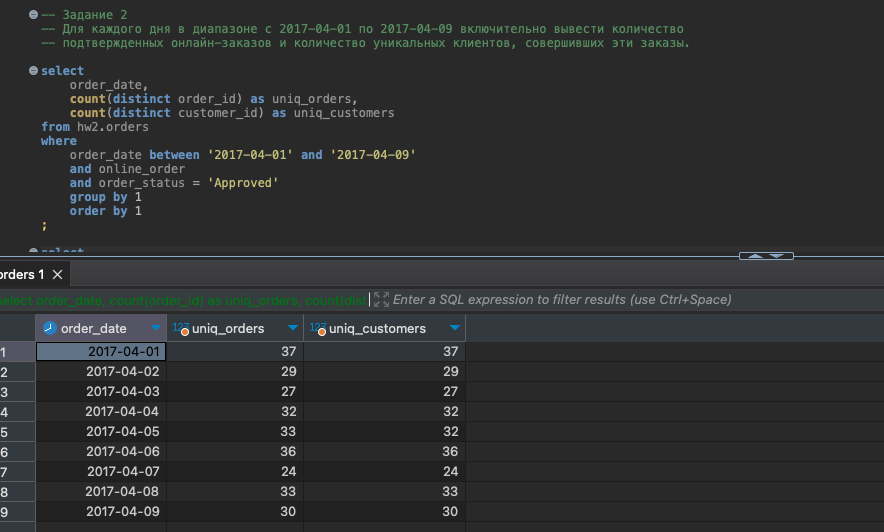

## Задание 3
```
-- Вывести профессии клиентов:
-- из сферы IT, чья профессия начинается с Senior;

-- из сферы Financial Services, чья профессия начинается с Lead.
-- Для обеих групп учитывать только клиентов старше 35 лет. Объединить выборки с помощью UNION ALL.


-- из сферы IT, профессия начинается с Senior, старше 35 лет - 2 чел
select job_title
from hw2.customer
where 
	(current_date - dob)/365 > 35
	and job_title ilike 'senior%'
	and job_industry_category = 'IT'
union all 
-- из сферы Financial Services, профессия начинается с Lead, старше 35 лет - 0 чел
select job_title
from hw2.customer
where 
	(current_date - dob)/365 > 35
	and job_title ilike 'lead%'
	and job_industry_category = 'Financial Services'
```

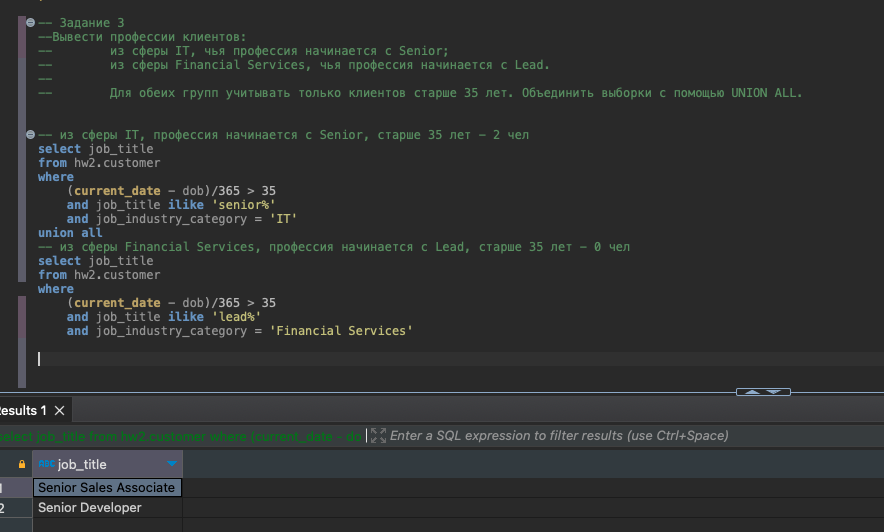

## Задание 4	
```
-- Вывести бренды, которые были куплены клиентами из сферы Financial Services,
-- но не были куплены клиентами из сферы IT.
	
-- бренды, купленные клиентами из сферы Financial Services: 6 шт
select 
	distinct brand
from hw2.order_items 
	left join hw2.orders on orders.order_id = order_items.order_id
	left join hw2.product_cor on product_cor.product_id = order_items.product_id
	left join hw2.customer on customer.customer_id = orders.customer_id
where job_industry_category = 'Financial Services' and order_status = 'Approved'
except
select -- бренды, купленные клиентами из сферы IT: 6 шт, те же самые
	distinct brand
from hw2.order_items 
	left join hw2.orders on orders.order_id = order_items.order_id
	left join hw2.product_cor on product_cor.product_id = order_items.product_id
	left join hw2.customer on customer.customer_id = orders.customer_id
where job_industry_category = 'IT' and order_status = 'Approved'
````

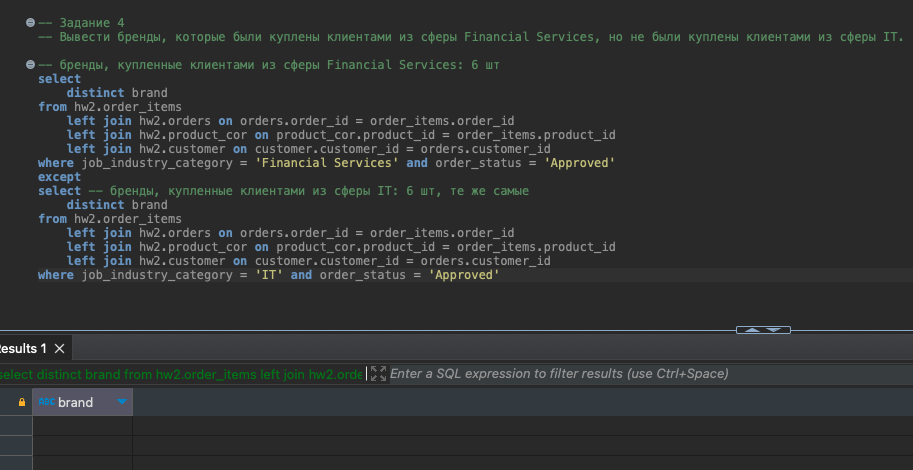

## Задание 5
```
-- Вывести 10 клиентов (ID, имя, фамилия), которые совершили наибольшее количество онлайн-заказов (в штуках)
-- брендов Giant Bicycles, Norco Bicycles, Trek Bicycles, при условии, что они активны и имеют
-- оценку имущества (property_valuation) выше среднего среди клиентов из того же штата.
    
with averages as (
	-- вывычисляем среднюю оценку имущества по штату
	select state, avg(property_valuation) as avg_state_valuation
	from hw2.customer
	group by 1
)
select 
	customer.customer_id,
	customer.first_name,
	customer.last_name
from hw2.order_items 
	left join hw2.orders on orders.order_id = order_items.order_id
	left join hw2.product_cor on product_cor.product_id = order_items.product_id
	left join hw2.customer on customer.customer_id = orders.customer_id
	left join averages on averages.state = customer.state
where 
	deceased_indicator = 'N'
	and	brand in ('Giant Bicycles', 'Norco Bicycles', 'Trek Bicycles')
	and online_order
	and order_status = 'Approved'
	and property_valuation > avg_state_valuation
group by 1, 2, 3
order by count(distinct orders.order_id) desc
limit 10 
```

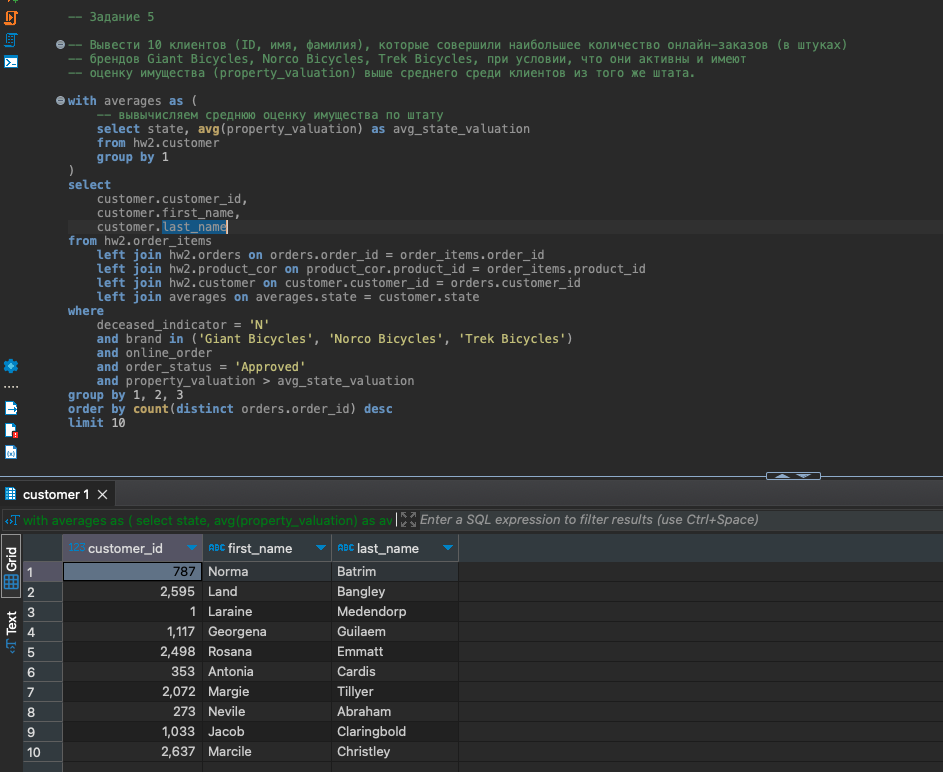

## Задание 6
```
-- Вывести всех клиентов (ID, имя, фамилия), у которых нет подтвержденных
-- онлайн-заказов за последний год, но при этом они владеют автомобилем и их сегмент благосостояния не Mass Customer.

-- ищем кастомеров с подтвержденными онлайн-заказами за последний год
-- пусто, потому что за последний год данных нет
with recent_customers as (
	select
		customer_id
	from hw2.orders
		left join hw2.customer using (customer_id)
	where 
		online_order
		and order_status = 'Approved'
		and order_date between current_date and current_date - interval '1 year'
)
-- теперь ищем всех кастомеров по условиям
select
	customer_id,
	first_name,
	last_name
from hw2.customer
where 
	customer_id not in (select customer_id from recent_customers)
	and wealth_segment != 'Mass Customer'
	and owns_car = 'Yes'
```

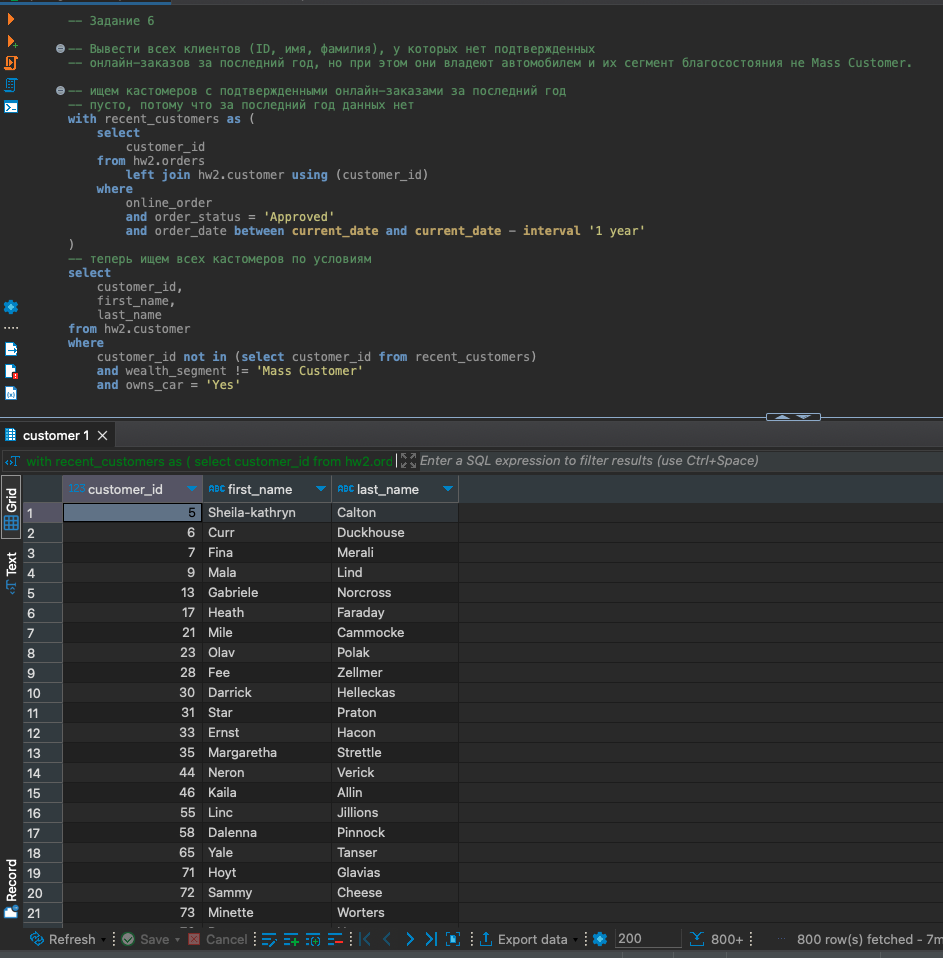

## Задание 7
```
--Вывести всех клиентов из сферы 'IT' (ID, имя, фамилия), которые купили
-- 2 из 5 продуктов с самой высокой list_price в продуктовой линейке Road.

-- 5 продуктов с самой высокой list_price в продуктовой линейке Road
with most_expensive_road_products as (
	select distinct 
		product_id, list_price	
	from hw2.product_cor
	where 
		product_line = 'Road'
	order by list_price desc
	limit 5
)
select 
	customer.customer_id,
	customer.first_name,
	customer.last_name
from hw2.order_items 
	left join hw2.orders on orders.order_id = order_items.order_id
	left join hw2.product_cor on product_cor.product_id = order_items.product_id
	left join hw2.customer on customer.customer_id = orders.customer_id
where 
	-- купили продукты с самой высокой list_price в продуктовой линейке Road.
	order_items.product_id in (select product_id from most_expensive_road_products)
	--  клиентов из сферы 'IT'
	and job_industry_category = 'IT'
-- купили 2 из 5 продуктов
group by 1,2,3
having count (distinct order_items.product_id) = 2
```

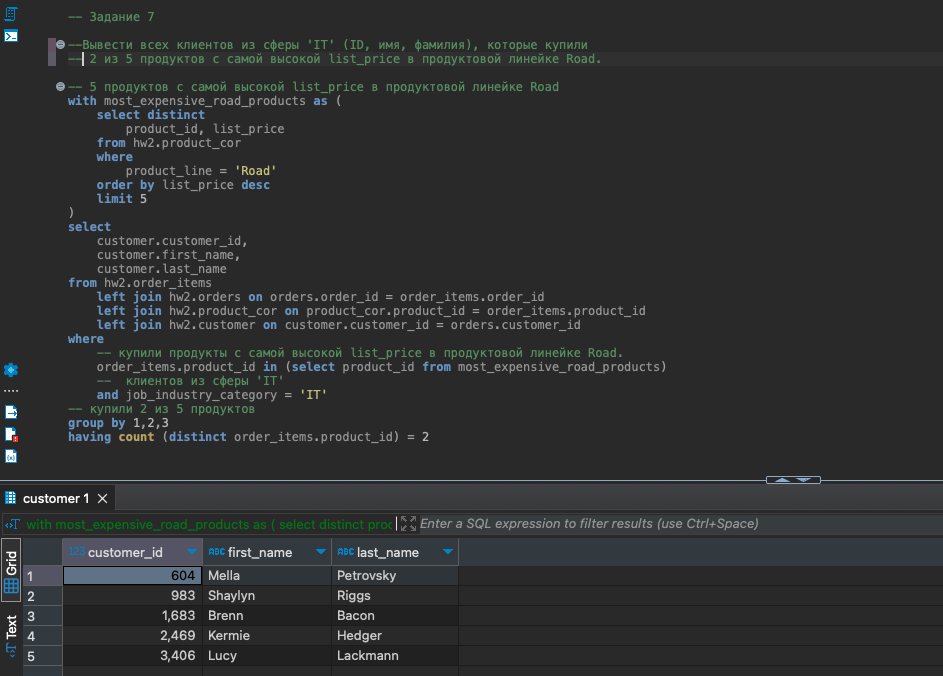

## Задание 8
```
-- Вывести клиентов (ID, имя, фамилия, сфера деятельности) из 
-- сфер IT или Health, которые совершили не менее 3
-- подтвержденных заказов в период 2017-01-01 по 2017-03-01,
-- и при этом их общий доход от этих заказов превышает 10 000 долларов.
--    Разделить вывод на две группы (IT и Health) с помощью UNION.


-- для IT нашлось ровно ноль человек
select 
	customer.customer_id,
	customer.first_name,
	customer.last_name
	--,count(distinct orders.order_id)
	--,sum(item_list_price_at_sale) 
from hw2.order_items 
	left join hw2.or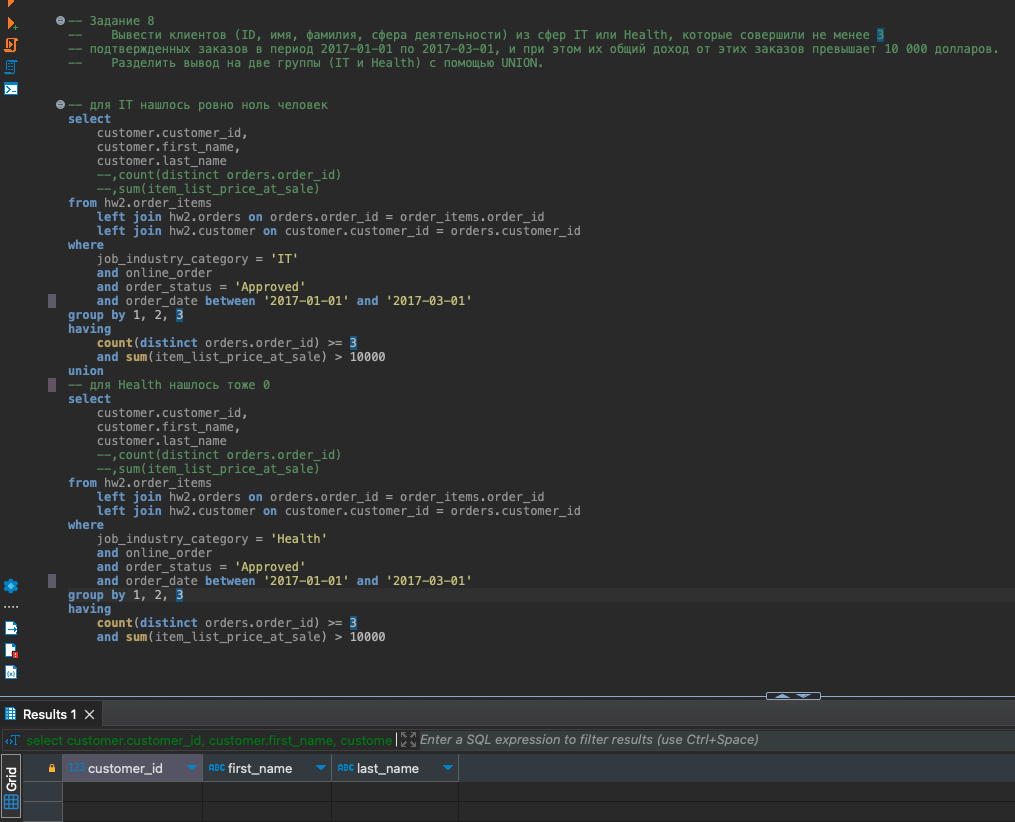ders on orders.order_id = order_items.order_id
	left join hw2.customer on customer.customer_id = orders.customer_id
where 
	job_industry_category = 'IT'
	and online_order
	and order_status = 'Approved'
	and order_date between '2017-01-01' and '2017-03-01'
group by 1, 2, 3
having 
	count(distinct orders.order_id) >= 3
	and sum(item_list_price_at_sale) > 10000
union
-- для Health нашлось тоже 0
select 
	customer.customer_id,
	customer.first_name,
	customer.last_name
	--,count(distinct orders.order_id)
	--,sum(item_list_price_at_sale) 
from hw2.order_items 
	left join hw2.orders on orders.order_id = order_items.order_id
	left join hw2.customer on customer.customer_id = orders.customer_id
where 
	job_industry_category = 'Health'
	and online_order
	and order_status = 'Approved'
	and order_date between '2017-01-01' and '2017-03-01'
group by 1, 2, 3
having 
	count(distinct orders.order_id) >= 3
	and sum(item_list_price_at_sale) > 10000
```

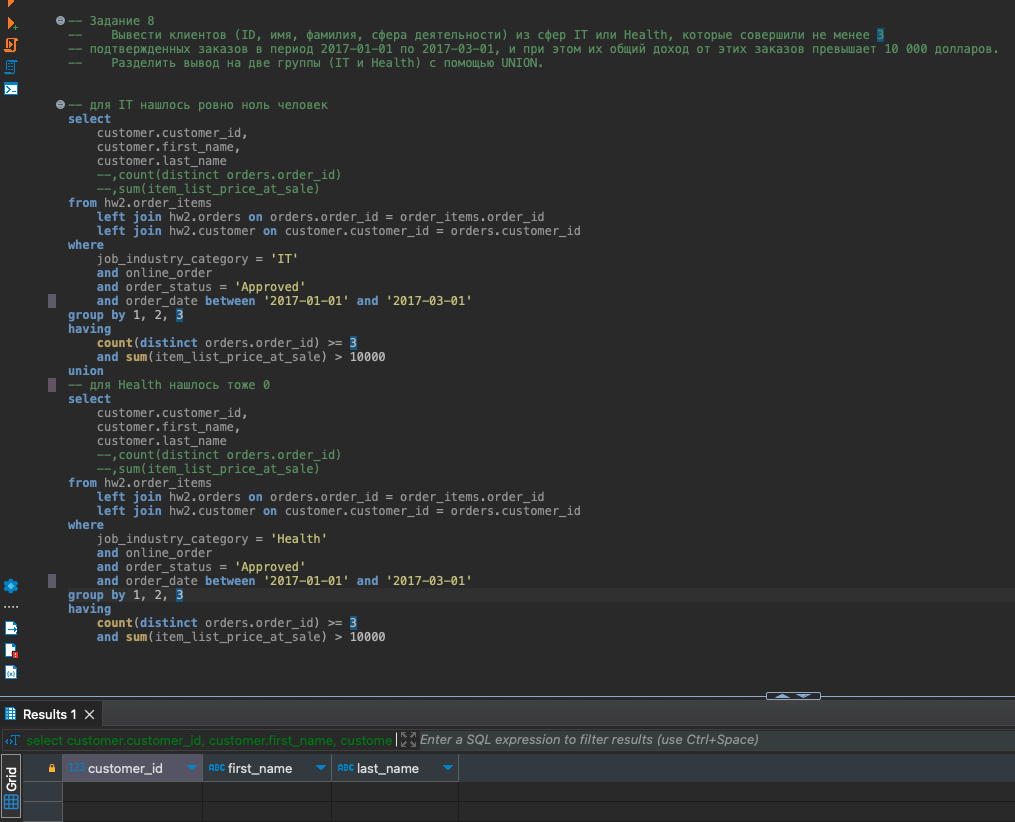